In [2]:
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, distance
import cv2
import numpy as np
import matplotlib.cm as cm
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.lines as mlines

In [373]:
column_names = ['frame','vehicle_id','vehicle_type','a','b','c','X1','Y1','X2','Y2',]
df = pd.read_csv("C:\\Users\\ancha\\Box\\QC-5900\\Data\\project2\\16393238\\segments\\16393238-cam_1-2-north_west-20231109_0000-010_1699916237331_out\\16393238-cam_1-2-north_west-20231109_0000-010_1699916237331.txt", sep=' ', header=None, usecols = [0,1,2,3,4,5,6,7,8,9], names=column_names)
df['Center_X'] = (df['X1']+df['X2']) / 2
df['Center_Y'] = (df['Y1']+df['Y2']) / 2

df = df[['frame','vehicle_id','vehicle_type','Center_X','Center_Y']]

In [374]:
print(df.shape)
df_unique = df.nunique()
df_unique

(70276, 5)


frame           30688
vehicle_id       1569
vehicle_type       10
Center_X         1265
Center_Y          650
dtype: int64

In [375]:
image_path = "C:\\Users\\ancha\\Box\\QC-5900\\Data\\project2\\16393238\\16393238-cam_1-2-north_west-20231109_0000_1699916237331_out\\16393238-cam_1-2-north_west-20231109_0000_1699916237331_frame.jpg"

In [376]:
df_sorted = df.sort_values(by=['vehicle_id','frame'])
df_sorted = df_sorted.groupby('vehicle_id').filter(lambda x: len(x) >= 15)
df_first_frame = df_sorted.groupby('vehicle_id').head(1).reset_index()
df_last_frame = df_sorted.groupby('vehicle_id').tail(1).reset_index()
df_combined = pd.concat([df_first_frame, df_last_frame]).sort_values(by='vehicle_id').reset_index()

In [377]:
print(df_first_frame.shape)
print(df_last_frame.shape)

(1222, 6)
(1222, 6)


In [378]:
# Assume df_first contains the first occurrence of each vehicle with 'x_center' and 'y_center'
# normalize X, Y coordinates
df_first_frame['Center_X_norm'] = (df_first_frame['Center_X'] - df_first_frame['Center_X'].mean()) / df_first_frame['Center_X'].std()
df_first_frame['Center_Y_norm'] = (df_first_frame['Center_Y'] - df_first_frame['Center_Y'].mean()) / df_first_frame['Center_Y'].std()

# Step 1: Extract the coordinates
X_first = df_first_frame[['Center_X_norm', 'Center_Y_norm']].values

# Step 2: Apply DBSCAN
# adjust epsilon ('eps') and min_samples based on data scale.
db = DBSCAN(eps=0.2, min_samples=20)  # eps is the maximum distance between two samples for them to be considered neighbors

# Step 3: Fit the DBSCAN model
df_first_frame['Cluster'] = db.fit_predict(X_first)
df_outlier = df_first_frame[df_first_frame['Cluster'] == -1].reset_index(drop=True)
df_first = df_first_frame[df_first_frame['Cluster'] != -1].reset_index(drop=True)

# Compute centroid of each cluster
centroids = df_first.groupby('Cluster')[['Center_X', 'Center_Y']].mean().reset_index()

# Display centroids
# print(centroids)

# Display no. of vehicles in each cluster
print(df_first['Cluster'].value_counts())
print(df_outlier.shape)



Cluster
0    650
1    375
3     92
4     45
2     39
Name: count, dtype: int64
(21, 9)


0 : (73.26, 152) : 650
1 : (593.54, 249) : 375
2 : (611.38, 306) : 39
3 : (49.06, 404) : 92
4 : (22.89, 337) : 45
   InClusterId InGate       Centroid                      Boundary
0            0      W   (73.26, 152)   (47.5, 121.5, 135.0, 186.0)
1            1      E  (593.54, 249)  (506.0, 622.5, 213.0, 281.0)
2            2      E  (611.38, 306)  (579.5, 626.5, 289.0, 333.0)
3            3      S   (49.06, 404)   (20.0, 102.5, 383.5, 421.0)
4            4      S   (22.89, 337)    (12.0, 65.0, 311.0, 357.0)


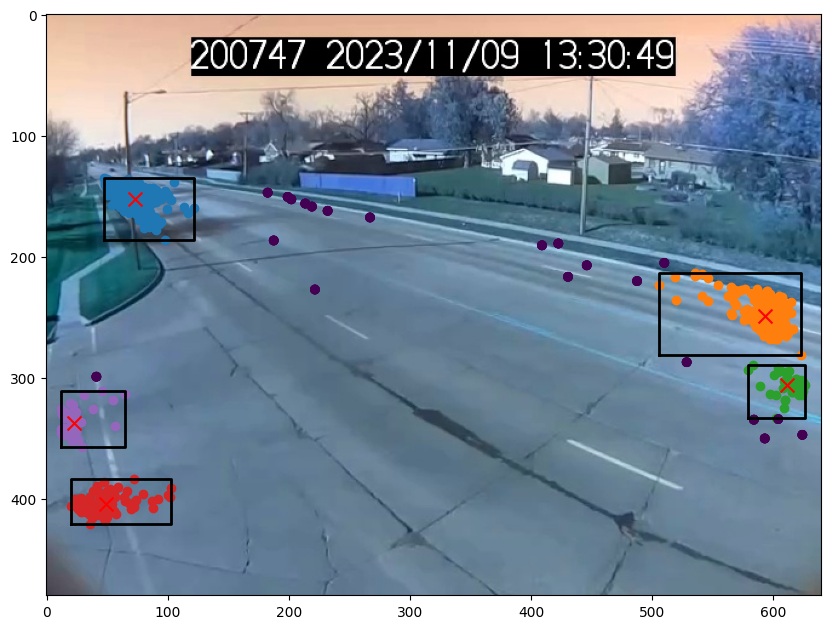

In [379]:
# Define the InGate mapping dictionary
in_gate_mapping = {0: 'W', 1: 'E', 2: 'E', 3: 'S', 4: 'S'}

df_first_clusters = df_first.copy()

# Store updated clusters
updated_clusters = []
fig, ax = plt.subplots(figsize=(10, 8))
for cluster_id, group in df_first_clusters.groupby('Cluster'):
    # centroid = group[['Center_X','Center_Y']].mean().values
    centroid = (round(float(group['Center_X'].mean()),2), round(float(group['Center_Y'].mean())))
    cluster_count = len(group)
    print(cluster_id, ":", centroid, ":", cluster_count)


    # Find the extreme points
    x_min = group.loc[group['Center_X'].idxmin(), 'Center_X']  # Leftmost point
    x_max = group.loc[group['Center_X'].idxmax(), 'Center_X']  # Rightmost point
    y_min = group.loc[group['Center_Y'].idxmin(), 'Center_Y']  # Bottommost point
    y_max = group.loc[group['Center_Y'].idxmax(), 'Center_Y']  # Topmost point
    
    # Identify outliers that are outside the cluster boundary
    outliers_outside_boundary = df_outlier[
        (df_outlier['Center_X'] < x_min) | (df_outlier['Center_X'] > x_max) |
        (df_outlier['Center_Y'] < y_min) | (df_outlier['Center_Y'] > y_max)
    ]
        
    # Define rectangle boundary
    rectangle_corners = np.array([
        [x_min, y_max],  # Top-left
        [x_max, y_max],  # Top-right
        [x_max, y_min],  # Bottom-right
        [x_min, y_min],  # Bottom-left
        [x_min, y_max]   # Close the rectangle
    ])

    # Plot the rectangle
    plt.plot(rectangle_corners[:, 0], rectangle_corners[:, 1], 'k-', linewidth=2)

    plt.scatter(df_outlier['Center_X'], df_outlier['Center_Y'], c = df_outlier['Cluster'])
    
    # Get InGate value using the cluster_id
    in_gate = in_gate_mapping.get(cluster_id, 'Unknown')  # Default to 'Unknown' if cluster_id not in the mapping

    # Append updated cluster data
    updated_clusters.append({
        'InClusterId': cluster_id,
        'InGate': in_gate,
        'Centroid': (centroid[0], centroid[1]),
        'Boundary': (x_min, x_max, y_min, y_max)
    })

    # Plot cluster points
    plt.scatter(group['Center_X'], group['Center_Y'], label=f'Cluster {cluster_id}')

    # Plot centroid
    plt.scatter(centroid[0], centroid[1], color='red', marker='x', s=100, label=f'Centroid {cluster_id}')

    ax.imshow(cv2.imread(image_path))

InGateClusters = pd.DataFrame(updated_clusters).sort_values('InClusterId').reset_index(drop=True)
print(InGateClusters)


In [380]:
# Assume df_last contains the last occurrence of each vehicle with 'x_center' and 'y_center'
# normalize X, Y coordinates
df_last_frame['Center_X_norm'] = (df_last_frame['Center_X'] - df_last_frame['Center_X'].mean()) / df_last_frame['Center_X'].std()
df_last_frame['Center_Y_norm'] = (df_last_frame['Center_Y'] - df_last_frame['Center_Y'].mean()) / df_last_frame['Center_Y'].std()

# Step 1: Extract the coordinates
X_last = df_last_frame[['Center_X_norm', 'Center_Y_norm']].values

# Step 2: Apply DBSCAN
# adjust epsilon ('eps') and min_samples based on data scale.
db = DBSCAN(eps=0.2, min_samples=20)  # eps is the maximum distance between two samples for them to be considered neighbors

# Step 3: Fit the DBSCAN model
df_last_frame['Cluster'] = db.fit_predict(X_last)
df_outlier_last = df_last_frame[df_last_frame['Cluster'] == -1].reset_index(drop=True)
df_last = df_last_frame[df_last_frame['Cluster'] != -1].reset_index(drop=True)


# Compute centroid of each cluster
centroids = df_last.groupby('Cluster')[['Center_X', 'Center_Y']].mean().reset_index()

# # Display centroids
# print(centroids)

# Display no. of vehicles in each cluster
print(df_last['Cluster'].value_counts())
print(df_outlier_last.shape)





Cluster
1    608
0    474
2    110
Name: count, dtype: int64
(30, 9)


0 : (108.22, 141) : 474
1 : (583.76, 402) : 608
2 : (7.58, 289) : 110
   OutClusterId OutGate       Centroid                      Boundary
0             0       W  (108.22, 141)   (54.5, 190.5, 126.0, 162.5)
1             1       E  (583.76, 402)  (453.5, 637.0, 336.0, 459.0)
2             2       S    (7.58, 289)     (2.0, 45.0, 261.5, 347.0)


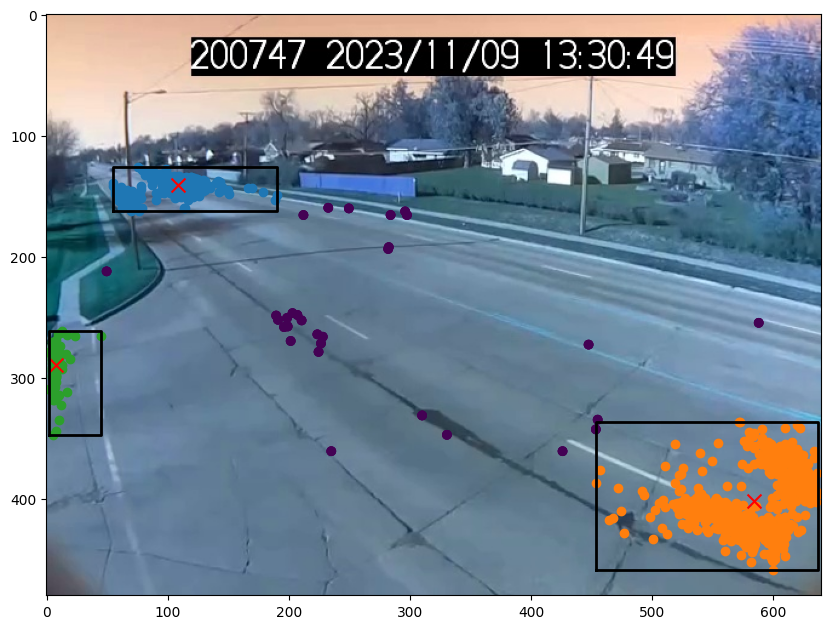

In [381]:
# Copy df_first to avoid modifying the original during iteration
# Define the InGate mapping dictionary
out_gate_mapping = {0: 'W', 1: 'E', 2: 'S', 3: 'E', 4: 'S'}

df_last_clusters = df_last.copy()

# Store updated clusters
updated_clusters = []
fig, ax = plt.subplots(figsize=(10, 8))
for cluster_id, group in df_last_clusters.groupby('Cluster'):
    centroid = (round(float(group['Center_X'].mean()),2), round(float(group['Center_Y'].mean())))
    cluster_count = len(group)
    print(cluster_id, ":", centroid, ":", cluster_count)
    
    # Find the extreme points
    x_min = group.loc[group['Center_X'].idxmin(), 'Center_X']  # Leftmost point
    x_max = group.loc[group['Center_X'].idxmax(), 'Center_X']  # Rightmost point
    y_min = group.loc[group['Center_Y'].idxmin(), 'Center_Y']  # Bottommost point
    y_max = group.loc[group['Center_Y'].idxmax(), 'Center_Y']  # Topmost point


    # Identify outliers that are outside the cluster boundary
    outliers_outside_boundary = df_outlier_last[
        (df_outlier_last['Center_X'] < x_min) | (df_outlier_last['Center_X'] > x_max) |
        (df_outlier_last['Center_Y'] < y_min) | (df_outlier_last['Center_Y'] > y_max)
    ]
    

    # Define rectangle boundary
    rectangle_corners = np.array([
        [x_min, y_max],  # Top-left
        [x_max, y_max],  # Top-right
        [x_max, y_min],  # Bottom-right
        [x_min, y_min],  # Bottom-left
        [x_min, y_max]   # Close the rectangle
    ])

    # Plot the rectangle
    plt.plot(rectangle_corners[:, 0], rectangle_corners[:, 1], 'k-', linewidth=2)

    plt.scatter(df_outlier_last['Center_X'], df_outlier_last['Center_Y'], c = df_outlier_last['Cluster'])

    # Get InGate value using the cluster_id
    out_gate = out_gate_mapping.get(cluster_id, 'Unknown')  # Default to 'Unknown' if cluster_id not in the mapping

    # Append updated cluster data
    updated_clusters.append({
        'OutClusterId': cluster_id,
        'OutGate': out_gate,  # Added InGate value
        'Centroid': centroid,
        'Boundary': (x_min, x_max, y_min, y_max)
    })

    # Plot cluster points
    plt.scatter(group['Center_X'], group['Center_Y'], label=f'Cluster {cluster_id}')

    # Plot centroid
    plt.scatter(centroid[0], centroid[1], color='red', marker='x', s=100, label=f'Centroid {cluster_id}')

    ax.imshow(cv2.imread(image_path))

OutGateClusters = pd.DataFrame(updated_clusters).sort_values('OutClusterId').reset_index(drop=True)
print(OutGateClusters)




In [382]:
df_first_clusters = df_first_clusters.rename(columns={'Cluster':'InCluster'})
df_last_clusters = df_last_clusters.rename(columns={'Cluster':'OutCluster'})
df_first_last = df_first_clusters[['vehicle_id','InCluster']].merge(df_last_clusters[['vehicle_id','OutCluster']],on='vehicle_id',how='outer')
print(df_first_last.nunique())

vehicle_id    1222
InCluster        5
OutCluster       3
dtype: int64


In [383]:
print(df_first_last[df_first_last['InCluster'].isnull()].shape)
print(df_first_last[df_first_last['OutCluster'].isnull()].shape)
print(df_first_last[(df_first_last['OutCluster'].isnull())&(df_first_last['InCluster'].isnull())].shape)
print(df_first_last[(df_first_last['OutCluster'].notnull())&(df_first_last['InCluster'].notnull())].shape)

(21, 3)
(30, 3)
(0, 3)
(1171, 3)


In [384]:
df_ingate_null = df_first_last[df_first_last['InCluster'].isnull()].merge(df_first_frame[['vehicle_id','Center_X','Center_Y']],on='vehicle_id',how='left')

# Convert centroids to NumPy array
centroids = np.array([cluster.Centroid for cluster in InGateClusters.itertuples()])
df_points = df_ingate_null[['Center_X', 'Center_Y']].values

# Find closest centroid index and distance
indices, distances = pairwise_distances_argmin_min(df_points, centroids)

# Assign the closest cluster and distance
df_ingate_null['InCluster'] = [InGateClusters.iloc[i].InClusterId for i in indices]
df_ingate_null['Min_Distance'] = distances
print(df_ingate_null.head(1))



   vehicle_id  InCluster  OutCluster  Center_X  Center_Y  Min_Distance
0          31          1         0.0     409.0     190.5    193.590448


In [385]:
df_ingate_null = df_ingate_null.merge(
    OutGateClusters[['OutClusterId', 'OutGate']], 
    how='left', 
    left_on='OutCluster', 
    right_on='OutClusterId'
)

# Merge with InGateClusters to get InGate
df_ingate_null = df_ingate_null.merge(
    InGateClusters[['InClusterId', 'InGate']], 
    how='left', 
    left_on='InCluster', 
    right_on='InClusterId'
)

# Display the updated df_ingate_null dataframe
print((df_ingate_null[['InCluster','InGate','OutCluster','OutGate']].value_counts().reset_index()))
# print((df_ingate_null[(df_ingate_null['InCluster'] == 2) & (df_ingate_null['OutCluster'] == 2)][['InCluster','OutCluster','Center_X','Center_Y']]))

   InCluster InGate  OutCluster OutGate  count
0          0      W         0.0       W      8
1          1      E         0.0       W      6
2          2      E         2.0       S      4
3          0      W         1.0       E      1
4          1      E         2.0       S      1
5          4      S         0.0       W      1


C:\Users\ancha\AppData\Local\Temp\ipykernel_13012\200665530.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))


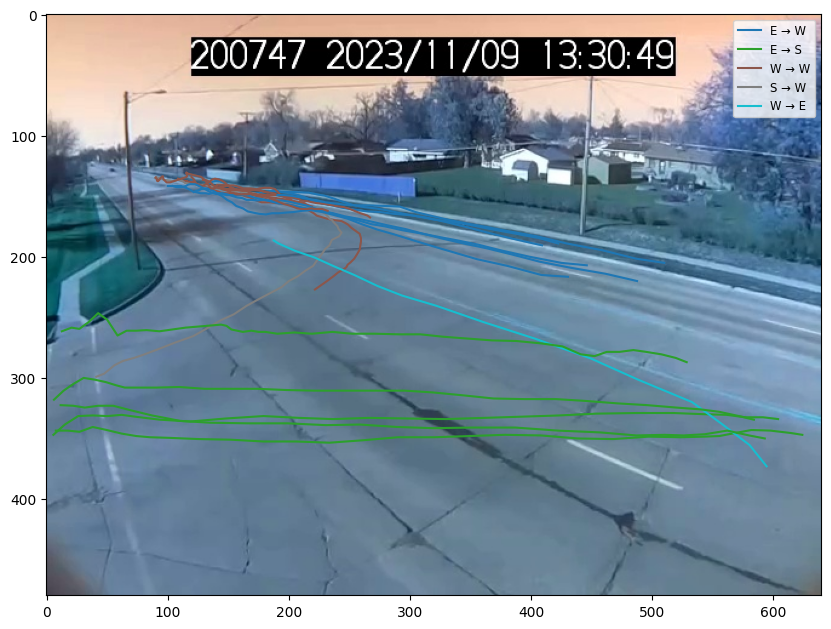

In [386]:
# Initialize a dictionary to store legend handles
legend_handles = {}
# Merge df_ingate_null with InGateClusters to get OutGate

df = df_sorted.merge(df_ingate_null[['vehicle_id','InCluster','OutCluster','InGate','OutGate']],on='vehicle_id',how='inner')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(cv2.imread(image_path))
# Get unique ('InGate', 'OutGate') pairs
unique_clusters = df[['InGate', 'OutGate']].drop_duplicates()
unique_clusters = [tuple(x) for x in unique_clusters.to_numpy()]  # Convert to list of tuples

# Create a colormap
cmap = cm.get_cmap('tab10', len(unique_clusters))

# Create a mapping from ('InGate', 'OutGate') to a color
color_mapping = {cluster_pair: cmap(i / len(unique_clusters)) for i, cluster_pair in enumerate(unique_clusters)}

# Group data by 'vehicle_id' and plot trajectory lines
for vehicle_id, group in df.groupby('vehicle_id'):
    # Extract the unique ('InGate', 'OutGate') pair for this vehicle
    cluster_pair = (group['InGate'].iloc[0], group['OutGate'].iloc[0])

    # Get the corresponding color
    color = color_mapping.get(cluster_pair, 'black')  # Default to black if not found

    ax.plot(group['Center_X'], group['Center_Y'], color = color, label=f'{cluster_pair[0]} → {cluster_pair[1]}')
    # Store legend entry only once per unique cluster pair
    if cluster_pair not in legend_handles:
        legend_handles[cluster_pair] = mlines.Line2D([], [], color=color, label=f'{cluster_pair[0]} → {cluster_pair[1]}')

# Add legend with correct color mapping
ax.legend(handles=legend_handles.values(), loc='best', fontsize='small', markerscale=0.5)

# Optional: Add legend to show cluster pairs
# ax.legend([f'Cluster {pair[0]} → {pair[1]}' for pair in unique_clusters], loc='best', fontsize='small', markerscale=0.5)


In [387]:
df_outgate_null = df_first_last[df_first_last['OutCluster'].isnull()].merge(df_last_frame[['vehicle_id','Center_X','Center_Y']],on='vehicle_id',how='left')

# Convert centroids to NumPy array
centroids = np.array([cluster.Centroid for cluster in OutGateClusters.itertuples()])
df_points = df_outgate_null[['Center_X', 'Center_Y']].values

# Find closest centroid index and distance
indices, distances = pairwise_distances_argmin_min(df_points, centroids)

# Assign the closest cluster and distance
df_outgate_null['OutCluster'] = [OutGateClusters.iloc[i].OutClusterId for i in indices]
df_outgate_null['Min_Distance'] = distances




In [388]:
df_outgate_null = df_outgate_null.merge(
    OutGateClusters[['OutClusterId', 'OutGate']], 
    how='left', 
    left_on='OutCluster', 
    right_on='OutClusterId'
)

# Merge with InGateClusters to get InGate
df_outgate_null = df_outgate_null.merge(
    InGateClusters[['InClusterId', 'InGate']], 
    how='left', 
    left_on='InCluster', 
    right_on='InClusterId'
)

# Display the updated df_ingate_null dataframe
print((df_outgate_null[['InCluster','InGate','OutCluster','OutGate']].value_counts().reset_index()))
# print((df_outgate_null[(df_outgate_null['InCluster'] == 2) & (df_outgate_null['OutCluster'] == 2)][['InCluster','OutCluster','Center_X','Center_Y']]))

   InCluster InGate  OutCluster OutGate  count
0        0.0      W           0       W     14
1        1.0      E           0       W      6
2        0.0      W           1       E      5
3        4.0      S           0       W      2
4        2.0      E           2       S      1
5        3.0      S           2       S      1
6        4.0      S           1       E      1


C:\Users\ancha\AppData\Local\Temp\ipykernel_13012\1279440328.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))


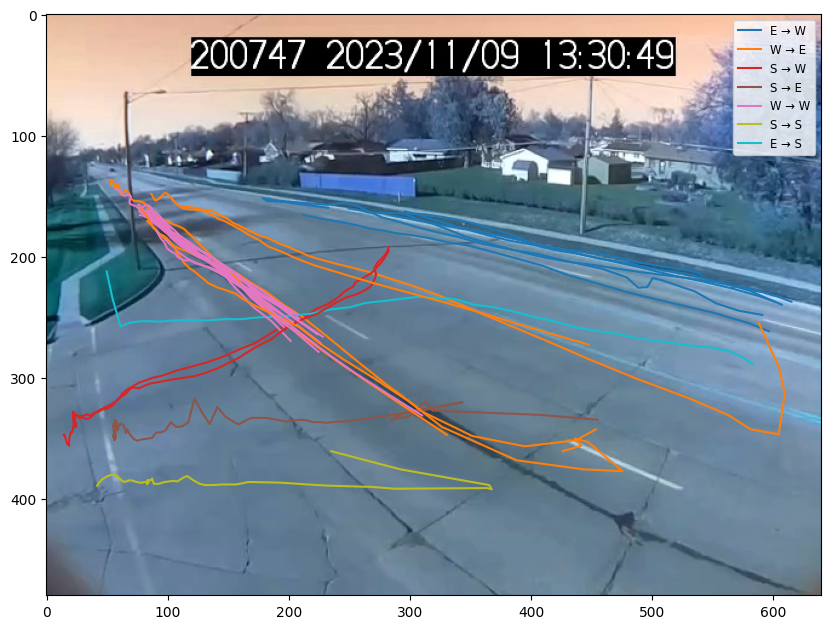

In [389]:
import matplotlib.lines as mlines

# Initialize a dictionary to store legend handles
legend_handles = {}
# Merge df_outgate_null with OutGateClusters to get OutGate


df = df_sorted.merge(df_outgate_null[['vehicle_id','InCluster','OutCluster','InGate','OutGate']],on='vehicle_id',how='inner')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(cv2.imread(image_path))
# Get unique ('InGate', 'OutGate') pairs
unique_clusters = df[['InGate', 'OutGate']].drop_duplicates()
unique_clusters = [tuple(x) for x in unique_clusters.to_numpy()]  # Convert to list of tuples

# Create a colormap
cmap = cm.get_cmap('tab10', len(unique_clusters))

# Create a mapping from ('InGate', 'OutGate') to a color
color_mapping = {cluster_pair: cmap(i / len(unique_clusters)) for i, cluster_pair in enumerate(unique_clusters)}

# Group data by 'vehicle_id' and plot trajectory lines
for vehicle_id, group in df.groupby('vehicle_id'):
    # Extract the unique ('InGate', 'OutGate') pair for this vehicle
    cluster_pair = (group['InGate'].iloc[0], group['OutGate'].iloc[0])

    # Get the corresponding color
    color = color_mapping.get(cluster_pair, 'black')  # Default to black if not found

    ax.plot(group['Center_X'], group['Center_Y'], color = color, label=f'{cluster_pair[0]} → {cluster_pair[1]}')
    # Store legend entry only once per unique cluster pair
    if cluster_pair not in legend_handles:
        legend_handles[cluster_pair] = mlines.Line2D([], [], color=color, label=f'{cluster_pair[0]} → {cluster_pair[1]}')

# Add legend with correct color mapping
ax.legend(handles=legend_handles.values(), loc='best', fontsize='small', markerscale=0.5)

# Optional: Add legend to show cluster pairs
# ax.legend([f'Cluster {pair[0]} → {pair[1]}' for pair in unique_clusters], loc='best', fontsize='small', markerscale=0.5)


In [390]:
# merges each vehicle's first frame cluster ID into df_sorted, ensuring consistent cluster IDs for all vehicle occurrences.
clustered_df_last = df_sorted.merge(df_first_last[['vehicle_id']],on='vehicle_id',how='inner')
print(clustered_df_last.shape)

(68380, 5)
